# Verification of INS filter performance by Monte Carlo simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyins

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 12

This example demonstrates how to implement Monte Carlo simulation to verify INS Kalman filter performance.

The Monte Carlo method follows the steps:

1. Setup the modelling trajectory, ideal measurements and statistical parameters of the errors
2. Execute the filter N time applying independent random errors according to the model.
   Record the estimate parameters errors and predicted standard deviations from the filter
3. Compute root-mean-squared (RMS) values of the errors and compare them with the standard deviations (SD) from the filter.
   The computed RMS values must be in a good agreement with SD values

Note that the variance of RMS is decreasing approximately as $1/N$ (and its SD as $1/\sqrt{N}$).
It means that getting low variance can require many repetitions.

In principle the runs can be executed in parralel (and probaly should for serious simulations).
In this case the random number generators in parralel threads must be independent from each other, which is not trivial to achieve.
Here we will use a single thread simulation with small number of repetitions.

## Trajectory setup

For simplicity we will use a synthetic (and not very realistic) trajectory consisting of loops along with a mean motion.

In [2]:
trajectory_true, imu_true = pyins.sim.sinusoid_velocity_motion(
    0.05, 600.0, [58, 56, 0], [10.0, -10.0, -1.0], 
    velocity_change_amplitude=60.0, velocity_change_period=30)

Let's visualize the trajectory in East-North plane.

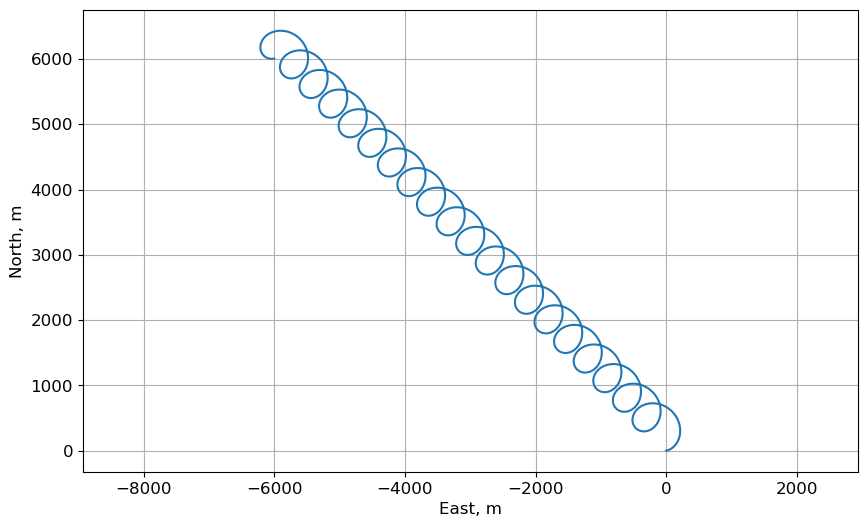

In [3]:
ned = pyins.transform.lla_to_ned(trajectory_true)

plt.plot(ned.east, ned.north)
plt.xlabel("East, m")
plt.ylabel("North, m")
plt.axis('equal');

Such trajectory allows for gyro scale factor and misalignment estimation for axis Z (because there is sufficient rotations around it). 

## Error and noise parameters

Now let's define error and noise parameters.

Initial position-velocity-attitude error standard deviations:

In [4]:
initial_position_sd = 10.0
initival_velocity_sd = 0.3
initial_level_sd = 0.1
initial_azimuth_sd = 0.5

For IMU we take a medium grade MEMS sensor.
We model initial bias, noise and misalignment and scale errors for gyros Z axis.

In [5]:
gyro_model = pyins.inertial_sensor.EstimationModel(
    bias_sd=100.0 * pyins.transform.DH_TO_RS, 
    noise=1.0 * pyins.transform.DRH_TO_RRS,
    bias_walk=10.0 * pyins.transform.DH_TO_RS / 60,
    scale_misal_sd=[[0, 0, 0.01], 
                    [0, 0, 0.01], 
                    [0, 0, 0.01]])

accel_model = pyins.inertial_sensor.EstimationModel(
    bias_sd=0.05,
    noise=0.1 / 60,
    bias_walk=0.001 / 60
)

As external measuremenets we use GNSS position fixes with the following parameters:

In [6]:
gnss_period = 1
gnss_position_sd = 2

## Running simulation

To represent the code in a more solid way, let's write function which execute a single run and the full simulation.

In [7]:
def run_single(trajectory_true, imu_true, gnss_lla_true,
               gyro_model, accel_model, 
               position_sd, velocity_sd, level_sd, azimuth_sd, 
               gnss_position_sd, filter_time_step, rng):
    gyro_parameters = pyins.inertial_sensor.Parameters.from_EstimationModel(gyro_model, rng=rng)
    accel_parameters = pyins.inertial_sensor.Parameters.from_EstimationModel(accel_model, rng=rng)
    
    imu = pyins.inertial_sensor.apply_imu_parameters(imu_true, 'rate', gyro_parameters, accel_parameters)
    increments = pyins.strapdown.compute_increments_from_imu(imu, 'rate')
    
    gnss_measurement = pyins.measurements.Position(
        pyins.sim.generate_position_measurements(gnss_lla_true, gnss_position_sd, rng), 
        gnss_position_sd)
    
    pva_error = pyins.sim.generate_pva_error(position_sd, velocity_sd, level_sd, azimuth_sd, rng=rng)
    pva_initial = pyins.sim.perturb_pva(trajectory_true.iloc[0], pva_error)
    
    filter_result = pyins.filters.run_feedback_filter(
        pva_initial, position_sd, velocity_sd, level_sd, azimuth_sd,
        increments, gyro_model, accel_model, 
        measurements=[gnss_measurement], time_step=filter_time_step)
        
    return pyins.util.Bunch(
        trajectory=pyins.transform.compute_state_difference(filter_result.trajectory, trajectory_true),
        gyro=pyins.transform.compute_state_difference(filter_result.gyro, gyro_parameters.data_frame),
        accel=pyins.transform.compute_state_difference(filter_result.accel, accel_parameters.data_frame),
        trajectory_sd=filter_result.trajectory_sd,
        gyro_sd=filter_result.gyro_sd,
        accel_sd=filter_result.accel_sd
    )

In [8]:
def run_monte_carlo(n_runs, trajectory_true, imu_true, 
                    gyro_model, accel_model, 
                    position_sd, velocity_sd, level_sd, azimuth_sd, 
                    gnss_period, gnss_position_sd, 
                    filter_time_step, rng):    
    gnss_lla_true = pyins.transform.resample_state(
        trajectory_true[pyins.util.LLA_COLS], 
        np.arange(trajectory_true.index[0], trajectory_true.index[-1], gnss_period))
    
    trajectory_error_sq = 0
    gyro_error_sq = 0
    accel_error_sq = 0

    trajectory_error_sd = 0
    gyro_error_sd = 0
    accel_error_sd = 0
    
    for run in range(n_runs):
        result = run_single(
            trajectory_true, imu_true, gnss_lla_true, 
            gyro_model, accel_model, 
            position_sd, velocity_sd, level_sd, azimuth_sd, 
            gnss_position_sd, filter_time_step, rng)
    
        trajectory_error_sq += result.trajectory ** 2
        gyro_error_sq += result.gyro ** 2
        accel_error_sq += result.accel ** 2

        trajectory_error_sd += result.trajectory_sd
        gyro_error_sd += result.gyro_sd
        accel_error_sd += result.accel_sd
            
    return pyins.util.Bunch(
        trajectory_rms=(trajectory_error_sq / n_runs) ** 0.5,
        gyro_rms=(gyro_error_sq / n_runs) ** 0.5,
        accel_rms=(accel_error_sq / n_runs) ** 0.5,
        trajectory_sd=trajectory_error_sd / n_runs,
        gyro_sd=gyro_error_sd / n_runs,
        accel_sd=accel_error_sd / n_runs
    )

Now let's run simulation with 100 repetitions.

In the filter we use 1 second for the covariance propagation.
This value is rather high for production algorithms, but it is sufficient for simulation purposes and will save us time.

Note that a single random generator must be used for all the runs to make the independent.

In [9]:
rng = np.random.RandomState(123456789)
filter_time_step = 1.0
n_runs = 100

mc_result = run_monte_carlo(
    n_runs, trajectory_true, imu_true, 
    gyro_model, accel_model, 
    initial_position_sd, initival_velocity_sd, initial_level_sd, initial_azimuth_sd,
    gnss_period, gnss_position_sd, 
    filter_time_step, rng)

## Result analysis

There is no single correct way to asses Monte Carlo simulation results.
One way is to plot RMS and SD curves and use qualitative judgement.

Implement a function to conveniently plot RMS and SD values.

In [10]:
def plot_rms_and_sd(rms, sd, title):
    n_states = rms.shape[1]
    n_cols = 3
    n_rows = (n_states + n_cols - 1) // n_cols    
    
    plt.figure(figsize=(3 * n_cols, 3 * n_rows))
    for i, col in enumerate(rms.columns, start=1):
        plt.subplot(n_rows, n_cols, i)
        plt.title(col)
        plt.plot(rms[col], label='rms')
        plt.plot(sd[col], label='sd')
        plt.ylim(0, plt.ylim()[1])
        plt.legend()
    
    plt.suptitle(title)
    plt.tight_layout()

Plot RMS and SD for trajectory, gyro and accelerometer parameter errors.

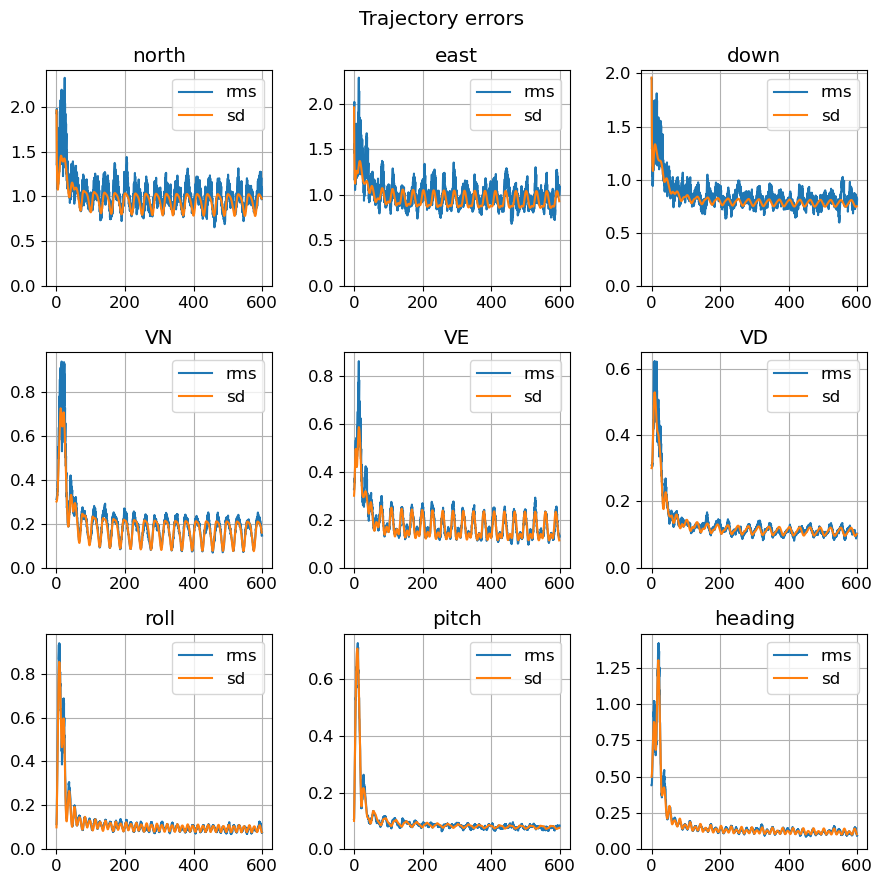

In [11]:
plot_rms_and_sd(mc_result.trajectory_rms, mc_result.trajectory_sd, "Trajectory errors")

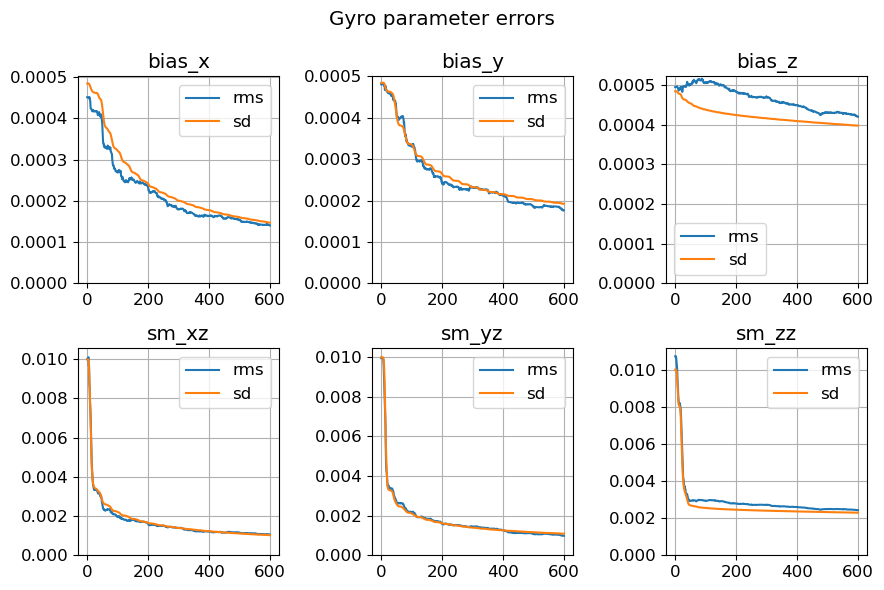

In [12]:
plot_rms_and_sd(mc_result.gyro_rms, mc_result.gyro_sd, "Gyro parameter errors")

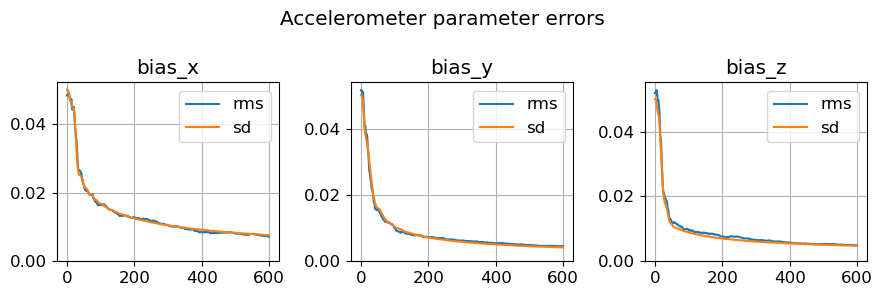

In [13]:
plot_rms_and_sd(mc_result.accel_rms, mc_result.accel_sd, "Accelerometer parameter errors")

Generally the following factors may contribute into the difference between RMS and SD:

1. Finite number of Monte Carlo runs
2. Approximate nature of the estimation algorithm (Extended Kalman Filter), especially when the errors are not sufficiently small (initial period)
3. Mismatch between truth and filter models
4. Bugs, mistakes and nuanses in the implementation

The purpose of Monte Carlo simulation is typically to eliminate the reasons 3 and 4, and if necessary tune and improve the algorithm by introducing some smart tweaks to it.

Here we observe an adequate match which tells us that probably issues 3 and 4 can be excluded. That is the algorithm is at least adequate, which was the goal for pyins code.